In [ ]:
import pandas as pd
import numpy as np
import impyute as impy
import math

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import sklearn.linear_model
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

from scipy import stats
import matplotlib.pyplot as plt
import shap

import os
#!pip install tslearn
#from tslearn.clustering import KShape
#from tslearn.clustering import silhouette_score
#tslearn not importing on my machine :(

import seaborn as sns

According the the CDC, sepsis (an acute response to infection) is a major problem for hospitals as 1 out of 3 patients who are in a hospital die of sepsis. Some of the risk factors for sepsis include people who have been diagnosed with an infection and people who have severe chronic conditions.

The purpose of our project is to explore the data’s features (of which there are 303) and determine which machine learning algorithm and pipeline most accurately classifies sepsis outcome and predicts if an incoming patient may have sepsis or may develop sepsis.

In [ ]:
# load first df
data = pd.read_csv('data')

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
# Replace 'None' with NaN
data.nan = data.replace('None', np.nan)

In [ ]:
# check for null type
obj = data.nan.isnull().sum()
for key,value in obj.iteritems():
    print(key,",",value)

In [ ]:
# Drop columns with >50% missing
df = data.nan.loc[:, data.nan.isnull().sum() < 0.5*data.nan.shape[0]]

# Drop rows with >50% missing
df = df.dropna(axis = 0, thresh = int((0.5*df.shape[1] + 1)))

In [ ]:
df.shape

In [ ]:
# Drop unnecessary columns
focus_df = df.drop(['a', 'b', 'c', 'd'], axis = 1)

In [ ]:
# Drop all prior labs
focus_df = focus_df.loc[:,~focus_df.columns.str.contains('^prior', case=False)]

In [ ]:
# check for null type
obj = focus_df.isnull().sum()
for key,value in obj.iteritems():
    print(key,",",value)

In [ ]:
# change 'object' type to float for imputation
focus_df1 = focus_df.astype(float, errors = 'raise')

# convert to array for imputation
y = focus_df1.values
data = impy.mode(y)

# convert back to dataframe
data = pd.DataFrame(data, columns = focus_df.columns.values.tolist())


In [ ]:
data.describe()

In [ ]:
# isolate vital signs data
signs_data = data.iloc[:, [36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53]]

In [ ]:
signs_data.describe()

In [ ]:
# isolate prior conditions data
condition_data = data.iloc[:, [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                                28,29,30,31,32,33,62]]

In [ ]:
condition_data.describe()

In [ ]:
condition_data = condition_data.astype('int64')

In [ ]:
# separate features and target
X = condition_data.drop(['label'], axis = 1)
X2 = signs_data
y = condition_data['label']

In [ ]:
# check for imbalanced data
y.value_counts()

In [ ]:
# Dendrogram of conditions
condition_clust = X.head(100)

linkage_matrix = linkage(condition_clust, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram Conditions')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [ ]:
# Dendrogram of signs
signs_clust = X2.head(100)

linkage_matrix = linkage(signs_clust, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram Signs')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [ ]:
# KShape clustering for exploratory data analysis
seed = np.random.seed(0)
sz = X.shape[0]

ks = KShape(n_clusters=3, verbose=True, random_state=seed)
ks_y_pred = ks.fit_predict(X)
print(silhouette_score(X, ks_y_pred))

# Plot the results
plt.figure(figsize=(10.0, 10.0))
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in data[ks_y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

ks = KShape(n_clusters=3, verbose=True, random_state=seed)
ks_y_pred = ks.fit_predict(X2)
print(silhouette_score(X2, ks_y_pred))

# Plot the results
plt.figure(figsize=(10.0, 10.0))
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in data[ks_y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

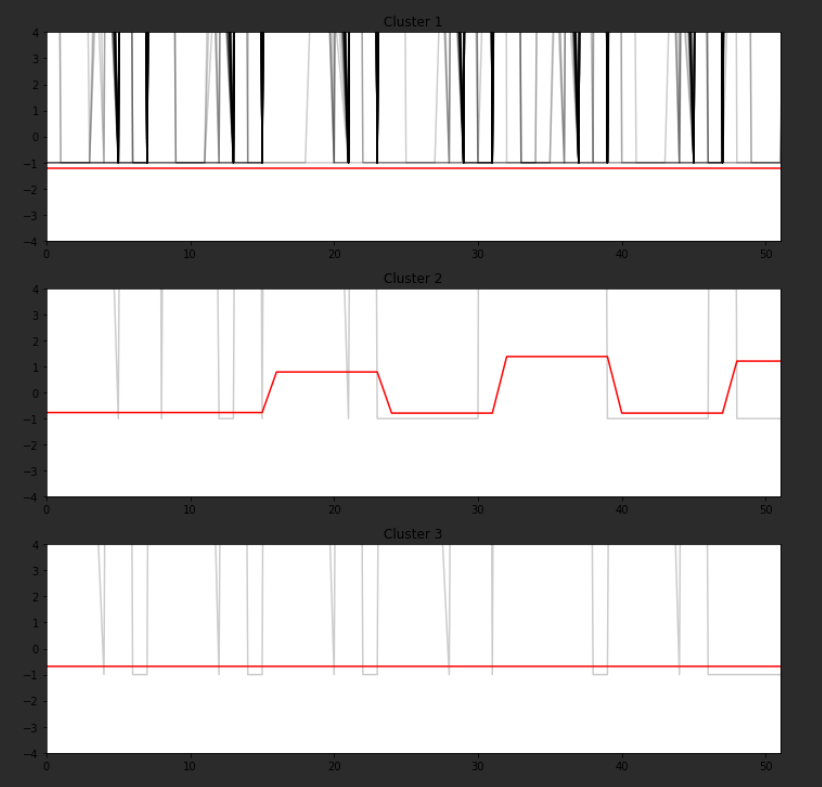

### Hypothesis: Based off of intial data exploration, conditions will be the best subset of data for prediction.

This approach would fit better into clinician workflow as past conditions could be scraped from the EHR. When a patient presents to the ICU with deterioration and is prone to sepsis based on past conditions (even when no vitals have been taken), a clinician could be alerted to record signs early and often to ensure sepsis does not occur.

In [ ]:
# Initialization
scalor=StandardScaler()
cv_outer = StratifiedKFold(n_splits=9, shuffle=True, random_state=1)
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
# Random Forrest Classifier

model_rf=RandomForestClassifier(random_state=1)
rf_pipeline = Pipeline([ 
    ('pca', PCA()), 
    ('model_rf',model_rf)
])
rf_param = {
               'model_rf__bootstrap': [True, False],
               'model_rf__max_depth': [2, 3, 5,7,9],
               'model_rf__max_features': ['log2', 'sqrt'],
               'model_rf__n_estimators': [10, 100, 500]}

rf_random = RandomizedSearchCV(rf_pipeline, rf_param, cv=cv_inner, scoring='f1')

In [ ]:
# XGBoost Classifier

model_xgb = xgb.XGBClassifier(random_state=1,objective='binary:logistic',eval_metric='logloss',use_label_encoder=False)
xgb_pipeline = Pipeline([
    ('pca', PCA()), 
    ('model_xgb', model_xgb)
])

xgb_param= {
    'model_xgb__max_depth': [2, 3, 5,7,9],
    'model_xgb__n_estimators': [10, 100, 500]}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1')

In [ ]:
# Logisitic Regression Classifier

model_log=LogisticRegression()
log_pipeline = Pipeline([ 
    ('pca', PCA()), 
    ('model_log',model_log)
])
log_param = {
               'model_log__max_iter': [50, 100, 500],
               'model_log__solver': ['liblinear'],
               'model_log__C': [0.1, 0.5, 1.0, 5, 10]}

log_random = RandomizedSearchCV(log_pipeline, log_param, cv=cv_inner, scoring='f1', random_state = 1)

In [ ]:
# Building Decision Tree model

model_dt=DecisionTreeClassifier()
dt_pipeline = Pipeline([ 
    ('pca', PCA()), 
    ('model_dt',model_dt)
])
dt_param = {
               'model_dt__max_depth': [None, 5, 10 , 50, 100],
               'model_dt__criterion': ['gini', 'entropy'],
               'model_dt__min_samples_split': [2, 4, 6, 8, 10]}

dt_random = RandomizedSearchCV(dt_pipeline, dt_param, cv=cv_inner, scoring='f1', random_state = 1)

In [ ]:
# Building SVC model

model_svm=SVC()
svm_pipeline = Pipeline([ 
    ('pca', PCA()), 
    ('model_svm',model_svm)
])
svm_param = {
               'model_svm__C': [0.1, 0.5, 1.0, 5, 10],
               'model_svm__kernel': ['linear'],
               'model_svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

svm_random = RandomizedSearchCV(svm_pipeline, svm_param, cv=cv_inner, scoring='f1', random_state = 1)

In [ ]:
# Bootstrapping for signs

Boot_splits2=[]
for i in range(0,10):
    Index=range(0,len(X2))
    X2_inbag, Y2_inbag = resample(X2, y, replace=True, n_samples=len(Index), random_state=i)

    #find the row index that is not in the in bag to put in out bag
    out_index = [y for y in X2.index if y not in X2_inbag.index]

    X2_outbag = X2.iloc[out_index]
    Y2_outbag = y.iloc[out_index]

    #add them all to one list
    Boot_splits2.append([X2_inbag, Y2_inbag, X2_outbag, Y2_outbag])

In [ ]:
# Running the models using RandomizedSearchCV with Bootstrapping for observations

rf_outer_results = list()
rf_best_f1_score=float('-inf')
rf_best_parameters={}

xgb_outer_results = list()
xgb_best_f1_score = float('-inf')
xgb_best_parameters = {}

log_outer_results = list()
log_best_f1_score=float('-inf')
log_best_parameters={}

dt_outer_results = list()
dt_best_f1_score=float('-inf')
dt_best_parameters={}

#svm_outer_results = list()
#svm_best_f1_score=float('-inf')
#svm_best_parameters={}

for i in range(len(Boot_splits2)):
    print('Iteration --> '+str(i))
    
    #Scaling numeric features
    scalor.fit(Boot_splits2[i][0])
    X_train=scalor.transform(Boot_splits2[i][0])
    X_test=scalor.transform(Boot_splits2[i][2])
    
    #Random Forrest
    search = rf_random
    result = search.fit(Boot_splits2[i][0], Boot_splits2[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits2[i][2])
    f1score = f1_score(Boot_splits2[i][3],yhat)
    if f1score >= rf_best_f1_score:
        rf_best_f1_score=f1score
        rf_best_parameters=result.best_params_
    rf_outer_results.append(f1score)
    print('Random Forrest inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    
    #XGBoost
    search = xgb_random
    result = search.fit(Boot_splits2[i][0], Boot_splits2[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits2[i][2])
    f1score = f1_score(Boot_splits2[i][3],yhat)
    if f1score >= xgb_best_f1_score:
        xgb_best_f1_score=f1score
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append(f1score)
    print('XGBoost inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))    

    #Logistic Regression
    search = log_random
    result = search.fit(Boot_splits2[i][0], Boot_splits2[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits2[i][2])
    f1score = f1_score(Boot_splits2[i][3],yhat)
    if f1score >= log_best_f1_score:
        log_best_f1_score=f1score
        log_best_parameters=result.best_params_
    log_outer_results.append(f1score)
    print('Logistic Regression inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    
    #Decision Tree
    search = dt_random
    result = search.fit(Boot_splits2[i][0], Boot_splits2[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits2[i][2])
    f1score = f1_score(Boot_splits2[i][3],yhat)
    if f1score >= dt_best_f1_score:
        dt_best_f1_score=f1score
        dt_best_parameters=result.best_params_
    dt_outer_results.append(f1score)
    print('Decision Tree inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))   
    

# summarize the estimated performance of the model
rf_mean2=np.mean(rf_outer_results)
xgb_mean2=np.mean(xgb_outer_results)
log_mean2=np.mean(log_outer_results)
dt_mean2=np.mean(dt_outer_results)

print('Random Forrest outer test: f1-score mean: %.3f (std: %.3f)' % (rf_mean2, np.std(rf_outer_results)))
print('XGBoost outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean2, np.std(xgb_outer_results)))
print('Logistic Regression outer test: f1-score mean: %.3f (std: %.3f)' % (log_mean2, np.std(log_outer_results)))
print('Decision Tree outer test: f1-score mean: %.3f (std: %.3f)' % (dt_mean2, np.std(dt_outer_results)))

In [ ]:
# Bootstrapping for conditions

Boot_splits=[]
for i in range(0,10):
    Index=range(0,len(X))
    X_inbag, Y_inbag = resample(X, y, replace=True, n_samples=len(Index), random_state=i)

    #find the row index that is not in the in bag to put in out bag
    out_index = [y for y in X.index if y not in X_inbag.index]

    X_outbag = X.iloc[out_index]
    Y_outbag = y.iloc[out_index]

    #add them all to one list
    Boot_splits.append([X_inbag, Y_inbag, X_outbag, Y_outbag])

In [ ]:
# Running the models using RandomizedSearchCV with Bootstrapping for conditions

rf_outer_results = list()
rf_best_f1_score=float('-inf')
rf_best_parameters={}

xgb_outer_results = list()
xgb_best_f1_score = float('-inf')
xgb_best_parameters = {}

log_outer_results = list()
log_best_f1_score=float('-inf')
log_best_parameters={}

dt_outer_results = list()
dt_best_f1_score=float('-inf')
dt_best_parameters={}

#svm_outer_results = list()
#svm_best_f1_score=float('-inf')
#svm_best_parameters={}

for i in range(len(Boot_splits)):
    print('Iteration --> '+str(i))
    
    #Random Forrest
    search = rf_random
    result = search.fit(Boot_splits[i][0], Boot_splits[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits[i][2])
    f1score = f1_score(Boot_splits[i][3],yhat)
    if f1score >= rf_best_f1_score:
        rf_best_f1_score=f1score
        rf_best_parameters=result.best_params_
    rf_outer_results.append(f1score)
    print('Random Forrest inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    
    #XGBoost
    search = xgb_random
    result = search.fit(Boot_splits[i][0], Boot_splits[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits[i][2])
    f1score = f1_score(Boot_splits[i][3],yhat)
    if f1score >= xgb_best_f1_score:
        xgb_best_f1_score=f1score
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append(f1score)
    print('XGBoost inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))    

    #Logistic Regression
    search = log_random
    result = search.fit(Boot_splits[i][0], Boot_splits[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits[i][2])
    f1score = f1_score(Boot_splits[i][3],yhat)
    if f1score >= log_best_f1_score:
        log_best_f1_score=f1score
        log_best_parameters=result.best_params_
    log_outer_results.append(f1score)
    print('Logistic Regression inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    
    #Decision Tree
    search = dt_random
    result = search.fit(Boot_splits[i][0], Boot_splits[i][1].values.ravel())
    best_model = result.best_estimator_
    yhat = best_model.predict(Boot_splits[i][2])
    f1score = f1_score(Boot_splits[i][3],yhat)
    if f1score >= dt_best_f1_score:
        dt_best_f1_score=f1score
        dt_best_parameters=result.best_params_
    dt_outer_results.append(f1score)
    print('Decision Tree inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))   
    

# summarize the estimated performance of the model
rf_mean=np.mean(rf_outer_results)
xgb_mean=np.mean(xgb_outer_results)
log_mean=np.mean(log_outer_results)
dt_mean=np.mean(dt_outer_results)

print('Random Forrest outer test: f1-score mean: %.3f (std: %.3f)' % (rf_mean, np.std(rf_outer_results)))
print('XGBoost outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean, np.std(xgb_outer_results)))
print('Logistic Regression outer test: f1-score mean: %.3f (std: %.3f)' % (log_mean, np.std(log_outer_results)))
print('Decision Tree outer test: f1-score mean: %.3f (std: %.3f)' % (dt_mean, np.std(dt_outer_results)))

In [ ]:
# summarize the estimated performance of the model
rf_mean=np.mean(rf_outer_results)
xgb_mean=np.mean(xgb_outer_results)
log_mean=np.mean(log_outer_results)
dt_mean=np.mean(dt_outer_results)

print('Random Forrest outer test: f1-score mean: %.3f (std: %.3f)' % (rf_mean, np.std(rf_outer_results)))
print('XGBoost outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean, np.std(xgb_outer_results)))
print('Logistic Regression outer test: f1-score mean: %.3f (std: %.3f)' % (log_mean, np.std(log_outer_results)))
print('Decision Tree outer test: f1-score mean: %.3f (std: %.3f)' % (dt_mean, np.std(dt_outer_results)))

In [ ]:
# Plot logistic regression for a feature

sns.regplot(x=X['hypertension'], y=y, data=X, logistic=True)
sns.regplot(x=X['hypertension'], y=y, data=X2, logistic=True)

In [ ]:
# T-test for significance

signs_f1 = (0.041, 0.129, 0.035, 0.193)
condition_f1 = (0.095, 0.252, 0.129, 0.275)

stats.ttest_ind(signs_f1, condition_f1)

Because p> 0.05, we cannot reject the null hypothesis, but conditions still perform better and make sense in the workflow.

In [ ]:
# Find the best model for condition

if (dt_mean and xgb_mean and dt_mean  <= log_mean):
    myFinalModel=model_log
    defaulttParm=model_log.get_params()
    for k in log_best_parameters.keys():
        if 'model_log' in k:
            parm=k.split('__')[1]
            defaulttParm[parm]=log_best_parameters[k]
    myFinalModel=LogisticRegression(**defaulttParm)
        
elif (xgb_mean and dt_mean and log_mean <= dt_mean):
    myFinalModel=model_dt
    defaulttParm=model_dt.get_params()
    for k in dt_best_parameters.keys():
        if 'model_dt' in k:
            parm=k.split('__')[1]
            defaulttParm[parm]=dt_best_parameters[k]
    myFinalModel=DecisionTreeClassifier(**defaulttParm)    

elif (dt_mean and log_mean and dt_mean <= xgb_mean):
    myFinalModel=model_xgb
    defaulttParm=model_xgb.get_params()
    for k in xgb_best_parameters.keys():
        if 'model_xgb' in k:
            parm=k.split('__')[1]
            defaulttParm[parm]=xgb_best_parameters[k]
    myFinalModel=xgb.XGBClassifier(**defaulttParm)     
    
else: 
    defaulttParm=model_dt.get_rf_params()
    for k in rf_best_parameters.keys():
        if 'model_rf' in k:
            parm=k.split('__')[1]
            defaulttParm[parm]=rf_best_parameters[k]
    defaulttParm['use_label_encoder']=False
    myFinalModel=RandomForestClassifier(**defaulttParm)

In [ ]:
print( myFinalModel)

In [ ]:
x_scaled=scalor.fit_transform(X)

In [ ]:
#Just best model
print(cross_val_score(myFinalModel,x_scaled, y,cv=9))

In [ ]:
# Perfrom Friedman's Teast
stats.friedmanchisquare(xgb_outer_results, log_outer_results, dt_outer_results, rf_outer_results)

p< 0.05 so Decision Tree performs the best statistically. 

In [ ]:
#SHAP with the best model without PCA

X_train, X_test, y_train, y_test = train_test_split(X.head(50), y.head(50), test_size=0.1, random_state=1)
myFinalModel.fit(X_train,y_train)
yhat=myFinalModel.predict(X_test)
f1score=f1_score(yhat,y_test)
print(f1score)

In [ ]:
# SHAP analysis for '0' label

shap.initjs()
#data = shap.sample(X_test, 100)
explainer = shap.KernelExplainer(myFinalModel.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)


In [ ]:
# SHAP analysis for '1' label

shap.initjs()
#data = shap.sample(X_test, 100)
explainer = shap.KernelExplainer(myFinalModel.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)